In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install graphviz

In [3]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime
from pandas import concat
from numpy import concatenate
from numpy import sqrt 
import seaborn as sns

import sklearn

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import scipy as sp
import time as time
import warnings
import arviz as az
import pymc3 as pm
from pymc3 import *

import pickle


In [4]:
from google.colab import drive
drive.mount('/content/drive')
home='/content/drive/My Drive/Tirocinio/Progetto IQVIA/New notebooks/exponential/sim/'

Mounted at /content/drive


## Carryover effect + Saturation

Carryover effect occurs when media spend effects sales across a number of days. For example, if we spend 1 on a specific media today, we may not see the effects of this spend for several days.


$adstock(x_{t-L+1,m} , ..., x_{t,m}; w_m,L) = \frac{\sum_{l=0}^{L-1} w_m(l)x_{t-l,m}}{\sum_{l=0}^{L-1}w_m(l)} $

Where:

* $m$ is media channel
* $w_m$ weight function - delayed_adstock 
* $L$ is the maximum duration of carryover effect

### Delayed adstock

$w_m^d  (l;\alpha_m, \theta_m) = \alpha_m^{(l-\theta_m)^2}$ 

$l= [0,...,L-1]$ 

 $0\le \alpha_m \le 1 $

 $0 \le \theta_m \le L-1$
 
 ### Saturation effect
 
Refers to the phenomenon of diminishing returns, colled also shape effects in the google paper. This arises when a media channel starts to loose its effectiveness, for example the difference between spending 0 and 10 is much larger than 100 and 110.

$ saturation = \beta (1-e^{-nux}) $


In [5]:
def saturation(x,nu,beta):
   return beta*(1 - np.exp(-nu*x))

#def saturation(x,nu):
#   return (1-np.exp(-nu*x))/(1+np.exp(-nu*x))


#def beta_hill(x, S, K, beta):
#    return beta - ((K**S)*beta)/(x**S+K**S)


def delayed_adstock(alpha, theta, L):
    return alpha**((np.ones(L).cumsum()-1)-theta)**2

def carryover(x, alpha, L, theta = None):
    '''
    1. x is a vector of media spend going back L timeslots, so it should be len(x) == L
    
    2. Weights is a vector of length L showing how much previous time periods spend has on current period. 
    
    3. L is max length of Lag.
    
    returns transformed vector of spend
    
    '''
    transformed_x = []

    weights = delayed_adstock(alpha, theta, L)
    
    for t in range(x.shape[0]):
        upper_window = t+1
        lower_window = max(0,upper_window-L)
        current_window_x = x[:upper_window]
        t_in_window = len(current_window_x)
        if t < L:
            new_x = (current_window_x*np.flip(weights[:t_in_window], axis=0)).sum()
            transformed_x.append(new_x/weights[:t_in_window].sum())
        elif t >= L:
            current_window_x = x[upper_window-L:upper_window]
            ext_weights = np.flip(weights, axis=0) 
            new_x = (current_window_x*ext_weights).sum()
            transformed_x.append(new_x/ext_weights.sum())
            
    return transformed_x

## Full model
In order to combine the carryover effect with the shape effect, we apply the adstock transformation to the time series of media spend, and then apply the shape transformation (saturation effect). Let $y_t$ be the sales at day $t$. The response can be modeled by the following equation:
$$
y_t = \tau + \sum_{m=1}^{M}Saturation(x_{t,m}^*;\nu, \beta)+\sum_{c=1}^{C}\gamma_c z_{t,c}+\epsilon_t
$$

where:
- $x_t$ has been transformed through the Adstock function 
- $z$ represents the control variables
- $\tau$ is the baseline sales
- $\gamma_c$ is the effect of control on the control variables $z_c$
- $\epsilon_t$ is some white noise that is assumed to be uncorrelated with the other variables

## Construction of features

In [7]:
N = 200 # number of data points

# media channels (simulated media)
X = [[],[],[]]

t = np.linspace(0, 10, N)
X[0]  = (100*(np.sin(t+1) + 10+np.random.randn(N)))
#X[0] = ((data-min(data))/(max(data)-min(data)) ) 

t = np.linspace(0, 10, N)
X[1]  = (100*(np.sin(t+1) + 10+np.random.randn(N)))
#X[1] = ((data-min(data))/(max(data)-min(data)) )  

t = np.linspace(0, 10, N)
X[2]  = (100*(np.sin(t+1) + 10+np.random.randn(N)))
#X[2] = ((data-min(data))/(max(data)-min(data)) ) 

X=np.array(X).reshape(200,3)

After generating the features' time series (media spend), I generate a synthetic dataset, including a price variable (as unique control variable) through AR(1) series and the price variable controlling all the parameters:

- Media 1
  - alpha = .6
  - theta = 5
  - beta     = 1.2
  - nu     = 2
- Media 2
  - alpha = .8
  - theta = 3
  - beta    = 2
  - nu     = 2
    
- Media 3
  - alpha = .8
  - theta = 4
  - beta = 1.5
  - nu = 2.8

In [8]:
#scaling the features
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X.reshape(600,-1)).reshape(200,3)


In [9]:
# price variable
from statsmodels.tsa import arima_process as arima

ar = [1, .7, .6] 
ma = [1, .1, .02] 
price_variable = arima.arma_generate_sample(ar,ma,N)


In [10]:
# true parameters
alpha_media_1 = .6
theta_media_1 = 5
b_media_1     = 1.2
nu_media_1     = 2


alpha_media_2 = .8
theta_media_2 = 3
b_media_2     = 2
nu_media_2     = 2


alpha_media_3 = .8
theta_media_3 = 4
b_media_3     = 1.5
nu_media_3     = 2.8


L=13
ru=4
lamb = -.5
ep = .3


#creation of sales variable:

m1 = [saturation(x, nu_media_1, b_media_1) for x in carryover(X[:,0], alpha_media_1, L, theta = theta_media_1)]
m2 = [saturation(x, nu_media_2, b_media_2) for x in carryover(X[:,1], alpha_media_2, L, theta = theta_media_2)]
m3 = [saturation(x, nu_media_3, b_media_3) for x in carryover(X[:,2], alpha_media_3, L, theta = theta_media_3)]
 

y = np.repeat(ru, N) + m1 + m2 + m3 + (lamb*price_variable) + np.random.normal(0, ep, N)

In [11]:
X_train = X[:120]
y_train = y[:120]
price_train = price_variable[:120]

### Features visualization

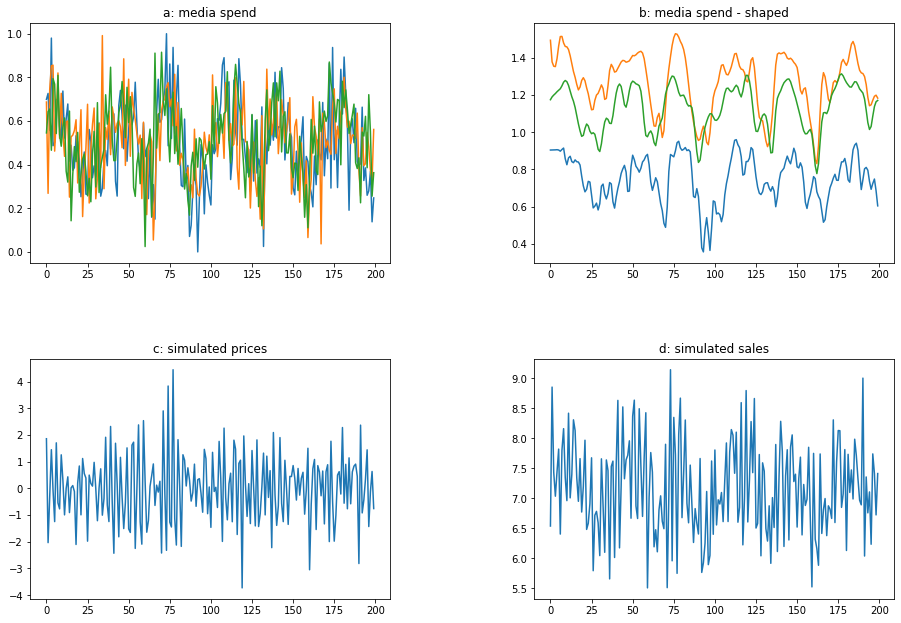

In [12]:
plt.rcParams["figure.figsize"] = (15,10)

figure, axis = plt.subplots(2, 2)
axis[0, 0].plot(X[:,0])
axis[0, 0].plot(X[:,1])
axis[0, 0].plot(X[:,2])
axis[0, 0].set_title('a: media spend')

axis[0, 1].plot(m1)
axis[0, 1].plot(m2)
axis[0, 1].plot(m3)
axis[0, 1].set_title('b: media spend - shaped')

axis[1, 0].plot(price_variable)
axis[1, 0].set_title('c: simulated prices')

axis[1, 1].plot(y)
axis[1, 1].set_title('d: simulated sales')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

## Model estimation and priors distributions


| Parameter | Prior         | Parameter  | Prior           |
|-----------|---------------|------------|-----------------|
| $\alpha$  | beta(2,2)     | $\tau$     | normal(0,5)     |
| $\theta$  | uniform(0,12) | $\lambda$  | normal(0,1)     |
| $nu$      | gamma(5,.1)    | $\epsilon$ | exponential(10) |
| $beta$    | gamma(2,2)    |           |                 |

In [13]:
#check features shape
X_train.shape, y_train.shape, price_train.shape

((120, 3), (120,), (120,))

In [ ]:
import arviz as az
from pymc3 import *
import pymc3 as pm

L=13
with pm.Model() as m:

    #var,      dist, pm.name,          params,  shape   
    alpha = pm.Beta('alpha',          2 , 2,  shape=3 ) # retain rate in adstock    (0 < alpha < 1)
    theta = pm.Uniform('theta',       0 , 12, shape=3 ) # delay weight in adstock   (0 < theta < L-1)
    beta  = pm.Gamma('beta',          3 , 1,  shape=3 ) # features coefficient      (> 0)
    nu    = pm.Gamma('nu',            3 , 2,  shape=3 ) # parameter for  saturation (>0)        
    tau   = pm.Normal('intercept',    0 , 5           ) # model intercept
    lamb  = pm.Normal('lamb'        , 0 , 5           ) # price coefficient
    noise = pm.InverseGamma('noise',  3 , .5          ) # variance about y 
    

    M1 = [saturation(x, nu[0], beta[0]) for x in carryover(X_train[:,0], alpha[0], L, theta = theta[0])]
    M2 = [saturation(x, nu[1], beta[1]) for x in carryover(X_train[:,1], alpha[1], L, theta = theta[1])]
    M3 = [saturation(x, nu[2], beta[2]) for x in carryover(X_train[:,2], alpha[2], L, theta = theta[2])]

    y_hat = pm.Normal('y_hat',   mu= tau + M1+M2+M3 + (lamb * price_train),
                      sigma=noise,   observed=y_train)

    trace1 = pm.sample(init = 'adapt_diag',target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [noise, lamb, intercept, nu, beta, theta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5493 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
with open(home+'model_sim2_exp_beta3_accept95_standard.pkl', 'wb') as buff:
    pickle.dump({'model': m, 'trace': trace1}, buff)

In [14]:
with open(home+'model_sim2_exp_beta3_accept95_standard.pkl', 'rb') as buff:
    data = pickle.load(buff)  

m, trace1 = data['model'], data['trace']

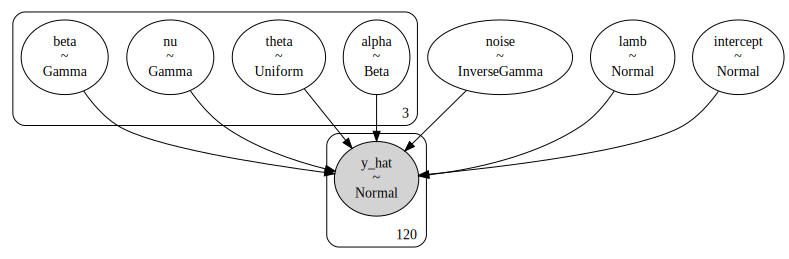

In [ ]:
pm.model_to_graphviz(m)

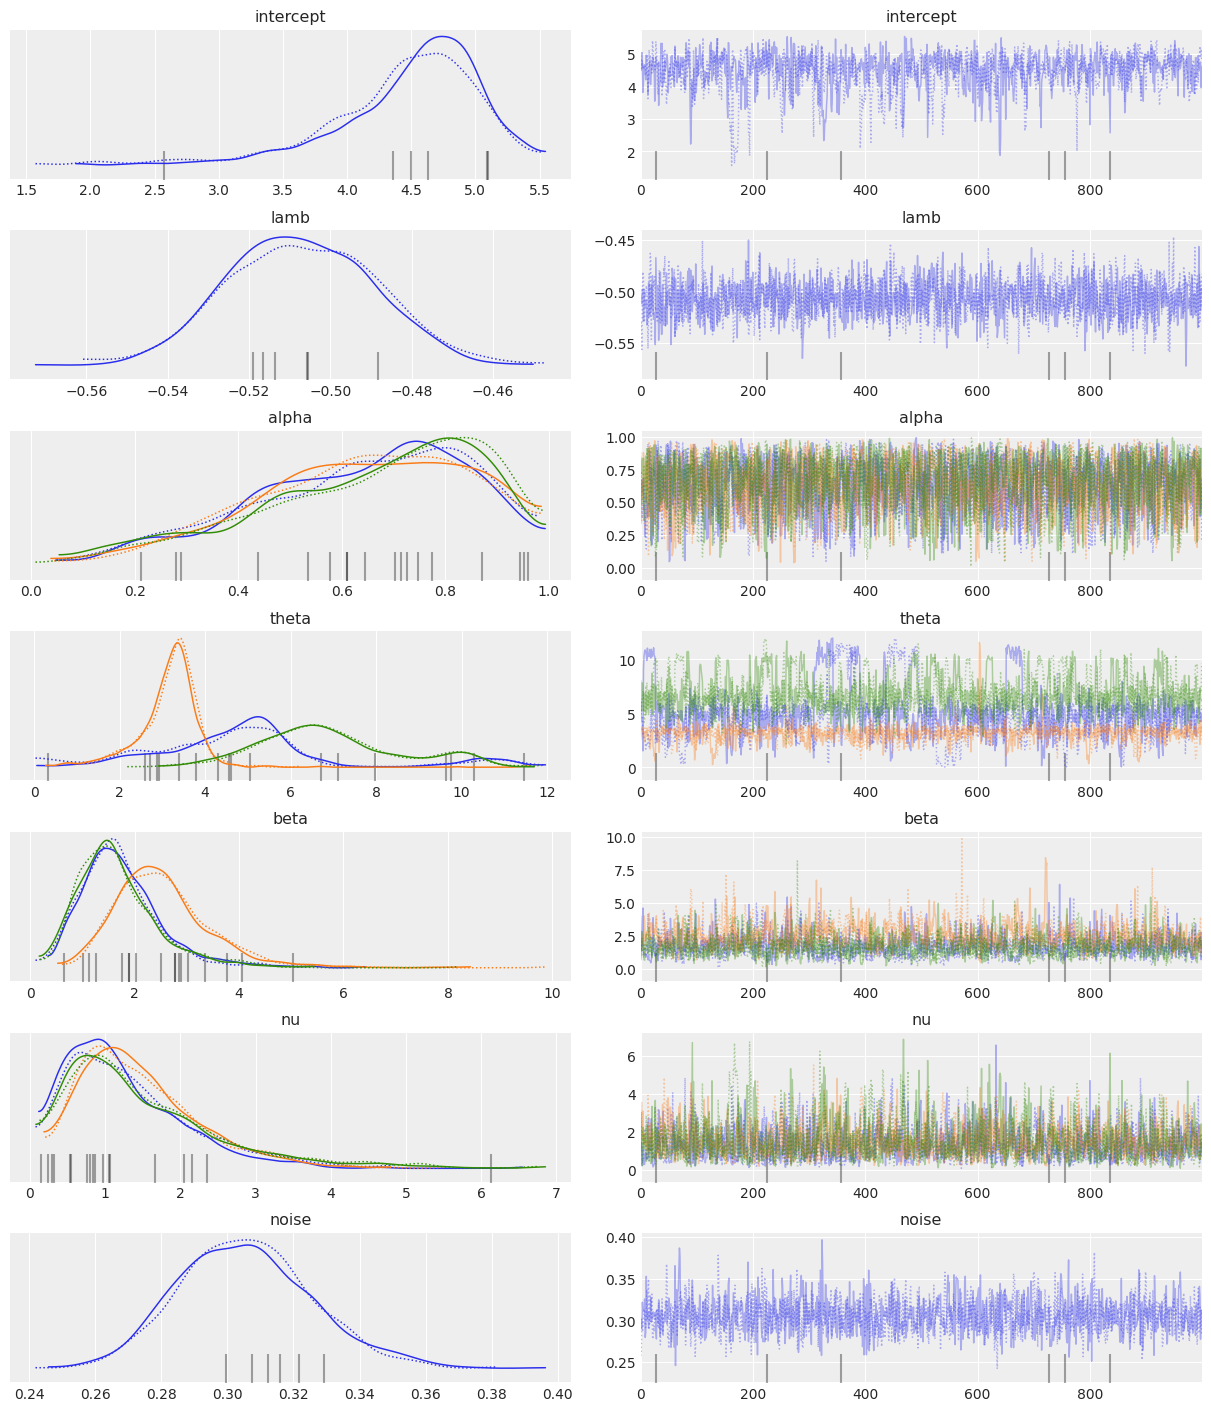

In [ ]:
az.style.use("arviz-darkgrid")
# Trace plots
with m:
    az.plot_trace(trace1)


In [15]:
az.summary(trace1, model=m)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,4.469,0.585,3.349,5.387,0.033,0.023,430.0,441.0,1.01
lamb,-0.507,0.018,-0.540,-0.473,0.000,0.000,1954.0,1545.0,1.00
alpha[0],0.631,0.207,0.245,0.965,0.005,0.004,1381.0,1370.0,1.00
alpha[1],0.634,0.203,0.263,0.961,0.007,0.005,826.0,1286.0,1.00
alpha[2],0.652,0.216,0.242,0.979,0.006,0.004,1328.0,938.0,1.00
theta[0],4.950,2.347,1.587,11.235,0.315,0.247,91.0,116.0,1.03
theta[1],3.155,0.745,1.600,4.156,0.031,0.022,691.0,579.0,1.00
theta[2],6.939,1.676,4.480,10.495,0.084,0.063,481.0,703.0,1.00
beta[0],1.729,0.776,0.471,3.078,0.032,0.023,503.0,611.0,1.01
beta[1],2.539,0.940,0.928,4.114,0.041,0.029,481.0,953.0,1.01


## Evaluate the model

In [16]:
predictors_out_of_sample = X[120:]
outcomes_out_of_sample = y[120:]
price_out_of_sample = price_variable[120:]

In [35]:
nu_sample= [[],[],[]]
a_sample = [[],[],[]]
t_sample = [[],[],[]]
b_sample = [[],[],[]]
inter=[]
lam=[]
nois=[]

for i in range(1000):
    burnin=500
    L=12
    s = np.random.randint(1,1000-burnin)
    t = np.random.randint(0, 2)
    intercept = trace1['intercept'].reshape(2,1000)[t][burnin:][s]
    lamb = trace1['lamb'].reshape(2,1000)[t][burnin:][s]
    sample_noise = trace1['noise'].reshape(2,1000)[t][burnin:][s]

    nu_sample1, nu_sample2, nu_sample3 = trace1['nu'][:,0].reshape(2,1000)[t][burnin:][s],    trace1['nu'][:,1].reshape(2,1000)[t][burnin:][s],     trace1['nu'][:,2].reshape(2,1000)[t][burnin:][s]
    a_sample1, a_sample2, a_sample3 =    trace1['alpha'][:,0].reshape(2,1000)[t][burnin:][s], trace1['alpha'][:,1].reshape(2,1000)[t][burnin:][s],  trace1['alpha'][:,2].reshape(2,1000)[t][burnin:][s]
    t_sample1, t_sample2, t_sample3 =    trace1['theta'][:,0].reshape(2,1000)[t][burnin:][s], trace1['theta'][:,1].reshape(2,1000)[t][burnin:][s],  trace1['theta'][:,2].reshape(2,1000)[t][burnin:][s]
    b_sample1, b_sample2, b_sample3 =    trace1['beta'][:,0].reshape(2,1000)[t][burnin:][s],  trace1['beta'][:,1].reshape(2,1000)[t][burnin:][s],  trace1['beta'][:,2].reshape(2,1000)[t][burnin:][s]

    
    nu_sample[0].append(nu_sample1)
    nu_sample[1].append(nu_sample2)     
    nu_sample[2].append(nu_sample3)

    a_sample[0].append(a_sample1)
    a_sample[1].append(a_sample2)     
    a_sample[2].append(a_sample3)

    t_sample[0].append(t_sample1)
    t_sample[1].append(t_sample2)     
    t_sample[2].append(t_sample3)

    b_sample[0].append(b_sample1)
    b_sample[1].append(b_sample2)     
    b_sample[2].append(b_sample3)
    
    nois.append(sample_noise)

    inter.append(intercept)
   
    lam.append(lamb)


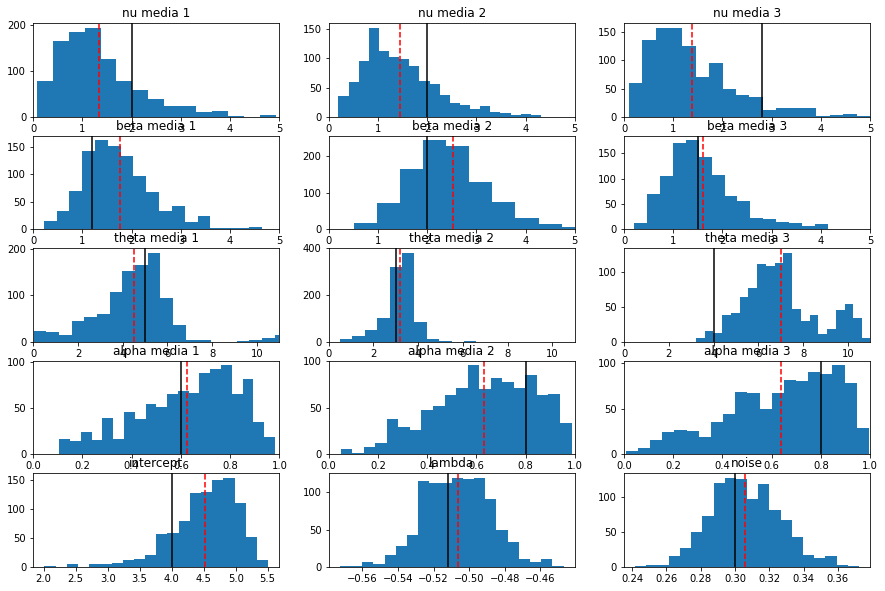

In [36]:
plt.rcParams["figure.figsize"] = (15,10)

f, axarr  = plt.subplots(5, 3)


axarr[0, 0].set_title('nu media 1')
axarr[0, 0].hist(nu_sample[0],bins=20)
axarr[0, 0].axvline(np.mean(nu_sample[0]), color="red", ls="--" )
axarr[0, 0].axvline(nu_media_1, color="black")
axarr[0, 1].set_title('nu media 2')
axarr[0, 1].hist(nu_sample[1],bins=20)
axarr[0, 1].axvline(np.mean(nu_sample[1]), color="red", ls="--" )
axarr[0, 1].axvline(nu_media_2, color="black")
axarr[0, 2].set_title('nu media 3')
axarr[0, 2].hist(nu_sample[2],bins=20)
axarr[0, 2].axvline(np.mean(nu_sample[2]), color="red", ls="--" )
axarr[0, 2].axvline(nu_media_3, color="black")

axarr[1, 0].set_title('beta media 1')
axarr[1, 0].hist(b_sample[0],bins=20)
axarr[1, 0].axvline(np.mean(b_sample[0]), color="red", ls="--" )
axarr[1, 0].axvline(b_media_1, color="black")
axarr[1, 1].set_title('beta media 2')
axarr[1, 1].hist(b_sample[1],bins=20)
axarr[1, 1].axvline(np.mean(b_sample[1]), color="red", ls="--" )
axarr[1, 1].axvline(b_media_2, color="black")
axarr[1, 2].set_title('beta media 3')
axarr[1, 2].hist(b_sample[2],bins=20)
axarr[1, 2].axvline(np.mean(b_sample[2]), color="red", ls="--" )
axarr[1, 2].axvline(b_media_3, color="black")


axarr[2, 0].set_title('theta media 1')
axarr[2, 0].hist(t_sample[0],bins=20)
axarr[2, 0].axvline(np.mean(t_sample[0]), color="red", ls="--" )
axarr[2, 0].axvline(theta_media_1, color="black")
axarr[2, 1].set_title('theta media 2')
axarr[2, 1].hist(t_sample[1],bins=20)
axarr[2, 1].axvline(np.mean(t_sample[1]), color="red", ls="--" )
axarr[2, 1].axvline(theta_media_2, color="black")
axarr[2, 2].set_title('theta media 3')
axarr[2, 2].hist(t_sample[2],bins=20)
axarr[2, 2].axvline(np.mean(t_sample[2]), color="red", ls="--" )
axarr[2, 2].axvline(theta_media_3, color="black")

axarr[3, 0].set_title('alpha media 1')
axarr[3, 0].hist(a_sample[0],bins=20)
axarr[3, 0].axvline(np.mean(a_sample[0]), color="red", ls="--" )
axarr[3, 0].axvline(alpha_media_1, color="black")
axarr[3, 1].set_title('alpha media 2')
axarr[3, 1].hist(a_sample[1],bins=20)
axarr[3, 1].axvline(np.mean(a_sample[1]), color="red", ls="--" )
axarr[3, 1].axvline(alpha_media_2, color="black")
axarr[3, 2].set_title('alpha media 3')
axarr[3, 2].hist(a_sample[2],bins=20)
axarr[3, 2].axvline(np.mean(a_sample[2]), color="red", ls="--" )
axarr[3, 2].axvline(alpha_media_3, color="black")

axarr[4, 0].set_title('intercept')
axarr[4, 0].hist(inter,bins=20)
axarr[4, 0].axvline(np.mean(inter), color="red", ls="--" )
axarr[4, 0].axvline(ru, color="black")
axarr[4, 1].set_title('lambda')
axarr[4, 1].hist(lam,bins=20)
axarr[4, 1].axvline(np.mean(lam), color="red", ls="--" )
axarr[4, 1].axvline(lamb, color="black")
axarr[4, 2].set_title('noise')
axarr[4, 2].hist(nois,bins=20)
axarr[4, 2].axvline(np.mean(nois), color="red", ls="--" )
axarr[4, 2].axvline(0.3, color="black")

axarr[0, 0].set_xlim([0, 5])
axarr[0, 1].set_xlim([0, 5])
axarr[0, 2].set_xlim([0, 5])

axarr[1, 0].set_xlim([0, 5])
axarr[1, 1].set_xlim([0, 5])
axarr[1, 2].set_xlim([0, 5])


axarr[2, 0].set_xlim([0, 11])
axarr[2, 1].set_xlim([0, 11])
axarr[2, 2].set_xlim([0, 11])

axarr[3, 0].set_xlim([0, 1])
axarr[3, 1].set_xlim([0, 1])
axarr[3, 2].set_xlim([0, 1])

plt.show()

In [17]:
pred = []

for i in range(1000):
    burnin=500
    L=12
    s = np.random.randint(1,1000-burnin)
    t = np.random.randint(0, 2)
    intercept = trace1['intercept'].reshape(2,1000)[t][burnin:][s]
    lamb = trace1['lamb'].reshape(2,1000)[t][burnin:][s]

    nu_sample1, nu_sample2, nu_sample3 = trace1['nu'][:,0].reshape(2,1000)[t][burnin:][s],    trace1['nu'][:,1].reshape(2,1000)[t][burnin:][s],     trace1['nu'][:,2].reshape(2,1000)[t][burnin:][s]
    a_sample1, a_sample2, a_sample3 =    trace1['alpha'][:,0].reshape(2,1000)[t][burnin:][s], trace1['alpha'][:,1].reshape(2,1000)[t][burnin:][s],  trace1['alpha'][:,2].reshape(2,1000)[t][burnin:][s]
    t_sample1, t_sample2, t_sample3 =    trace1['theta'][:,0].reshape(2,1000)[t][burnin:][s], trace1['theta'][:,1].reshape(2,1000)[t][burnin:][s],  trace1['theta'][:,2].reshape(2,1000)[t][burnin:][s]
    b_sample1, b_sample2, b_sample3 =    trace1['beta'][:,0].reshape(2,1000)[t][burnin:][s],  trace1['beta'][:,1].reshape(2,1000)[t][burnin:][s],  trace1['beta'][:,2].reshape(2,1000)[t][burnin:][s]

   
    fitted_m1 = [ saturation(x, nu_sample1,b_sample1) for x in carryover(predictors_out_of_sample[:,0], a_sample1, L, theta = t_sample1)]
    fitted_m2 = [ saturation(x, nu_sample2,b_sample2) for x in carryover(predictors_out_of_sample[:,1], a_sample2, L, theta = t_sample2)]
    fitted_m3 = [ saturation(x, nu_sample3,b_sample3) for x in carryover(predictors_out_of_sample[:,2], a_sample3, L, theta = t_sample3)]
    
    pred.append(intercept + fitted_m1 + fitted_m2 + fitted_m3  + (lamb * price_out_of_sample))
     


Plot of actual and predicted sell for the test set:

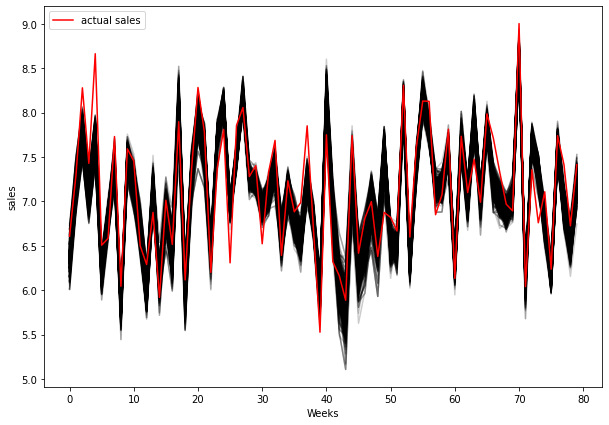

In [18]:
plt.rcParams["figure.figsize"] = (10,7)

for i  in range(1000):
  plt.plot(pred[i],alpha=0.2, color="black")
plt.plot(outcomes_out_of_sample, color="red", label = "actual sales")
plt.xlabel('Weeks')
plt.ylabel('sales')
plt.legend( fancybox=True)
plt.show()

In [19]:
pred_mean = np.array(pred).mean(axis=0)

In [20]:
import math

mse = sklearn.metrics.mean_squared_error(outcomes_out_of_sample, pred_mean)
rmse = math.sqrt(mse)

print("MSE:  ", mse)
print("RMSE: ", rmse)


MSE:   0.09526920560123758
RMSE:  0.30865710035772315


## ROAS Calculation

The predicted sales is the sum of the first three terms in the main model's formula , excluding the noise term. 

ROAS is the change in revenue (or sales) per dollar spent on the medium and is usually calculated by setting spend of the medium to zero in the selected time period and comparing the predicted revenue against that of the current media spend.

Let $\hat{Y}_t$ denote the predicted sales, which depends on media X, control variables $Z$ and parameters $\Phi$. Suppose the historical spend of the $m$th channel is denoted by $x_{t,m}$ while $\tilde{x}_{t,m}$ is the spend of the same channel set to 0 for the selected time period, The predicted sales using all historical spend is denoted with $\hat{Y}_t^m(x_{t-L+1,m},...,x_{t,m};\Phi)$ , while the predicted sales using all the spend but the $m$th channel to evaluate (which is set to 0) is denoted by $\hat{Y}_t^m(\tilde{x}_{t-L+1,m},...,\tilde{x}_{t,m};\Phi)$
ROAS on the media $m$th si calculated as:

$$
ROAS_m = \frac{\sum_{t_0 \le t \le t_1+L-1} \hat{Y}_t^m(x_{t-L+1,m},...,x_{t,m};\Phi) - \hat{Y}_t^m(\tilde{x}_{t-L+1,m},...,\tilde{x}_{t,m};\Phi)}{\sum_{t_0 \le t \le t_1} x_{t,m}}
$$

In [21]:
media_1_roas = []
media_2_roas = []
media_3_roas = []


for i in range(1000):
    burnin=500
    L=12
    s = np.random.randint(1,1000-burnin)
    t = np.random.binomial(1,.5)
    intercept = trace1['intercept'].reshape(2,1000)[t][burnin:][s]
    lamb = trace1['lamb'].reshape(2,1000)[t][burnin:][s]
    
    nu_sample1, nu_sample2, nu_sample3 = trace1['nu'][:,0].reshape(2,1000)[t][burnin:][s],    trace1['nu'][:,1].reshape(2,1000)[t][burnin:][s],     trace1['nu'][:,2].reshape(2,1000)[t][burnin:][s]
   
    a_sample1, a_sample2, a_sample3 =    trace1['alpha'][:,0].reshape(2,1000)[t][burnin:][s], trace1['alpha'][:,1].reshape(2,1000)[t][burnin:][s],  trace1['alpha'][:,2].reshape(2,1000)[t][burnin:][s]
    t_sample1, t_sample2, t_sample3 =    trace1['theta'][:,0].reshape(2,1000)[t][burnin:][s], trace1['theta'][:,1].reshape(2,1000)[t][burnin:][s],  trace1['theta'][:,2].reshape(2,1000)[t][burnin:][s]
    b_sample1, b_sample2, b_sample3 =    trace1['beta'][:,0].reshape(2,1000)[t][burnin:][s],  trace1['beta'][:,1].reshape(2,1000)[t][burnin:][s],  trace1['beta'][:,2].reshape(2,1000)[t][burnin:][s]

    fitted_m1 = [saturation(x, nu_sample1, b_sample1) for x in carryover(X[:,0], a_sample1, L, theta = t_sample1)]
    fitted_m2 = [saturation(x, nu_sample2, b_sample2) for x in carryover(X[:,1], a_sample2, L, theta = t_sample2)]
    fitted_m3 = [saturation(x, nu_sample3, b_sample3) for x in carryover(X[:,2], a_sample3, L, theta = t_sample3)]  
 
    y_hat    = intercept + fitted_m1 + fitted_m2 + fitted_m3 + (lamb * price_variable)
     
    y_hat_m1 = intercept + fitted_m2 + fitted_m3 + (lamb * price_variable)
    y_hat_m2 = intercept + fitted_m1 + fitted_m3 + (lamb * price_variable)
    y_hat_m3 = intercept + fitted_m1 + fitted_m2 + (lamb * price_variable)

    media_1_roas.append((y_hat[L:]-y_hat_m1[L:]).sum() / X[:,0][L:len(X[:,0]-L)].sum())
    media_2_roas.append((y_hat[L:]-y_hat_m2[L:]).sum() / X[:,1][L:len(X[:,1]-L)].sum())
    media_3_roas.append((y_hat[L:]-y_hat_m3[L:]).sum() / X[:,2][L:len(X[:,2]-L)].sum())

In [22]:
print( 'ROAS for media 1 is' , np.median(media_1_roas).round(4),'and SD' , np.std(media_1_roas).round(4)) 
print( 'ROAS for media 2 is' , np.median(media_2_roas).round(4),'and SD' , np.std(media_2_roas).round(4))
print( 'ROAS for media 3 is' , np.median(media_3_roas).round(4),'and SD' , np.std(media_3_roas).round(4))

ROAS for media 1 is 1.2802 and SD 0.7959
ROAS for media 2 is 2.1377 and SD 0.8961
ROAS for media 3 is 1.2157 and SD 0.7656


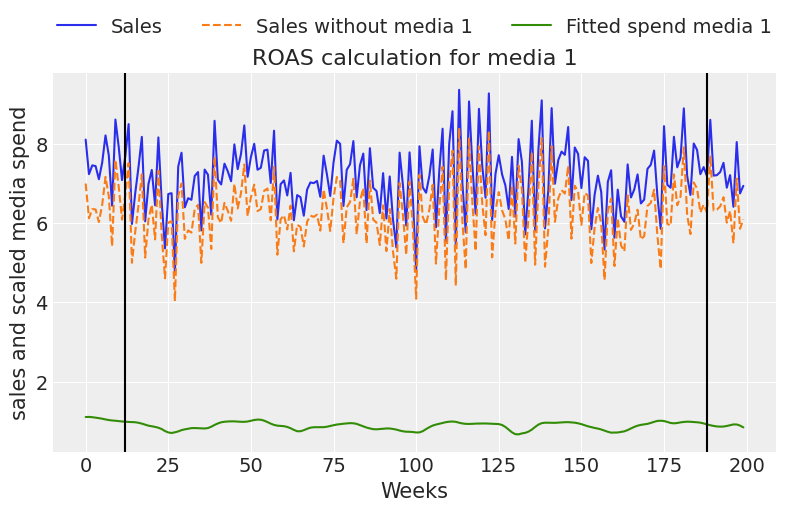

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(y_hat, label = "Sales")
plt.plot(y_hat_m1, label = "Sales without media 1", ls="--")

plt.plot(fitted_m1, label = "Fitted spend media 1")


plt.axvline(12, 0, 1, color="black")
plt.axvline(200-12, 0, 1, color="black")

plt.xlabel('Weeks')
plt.ylabel('sales and scaled media spend')
plt.title('ROAS calculation for media 1')
 
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True)
plt.show()

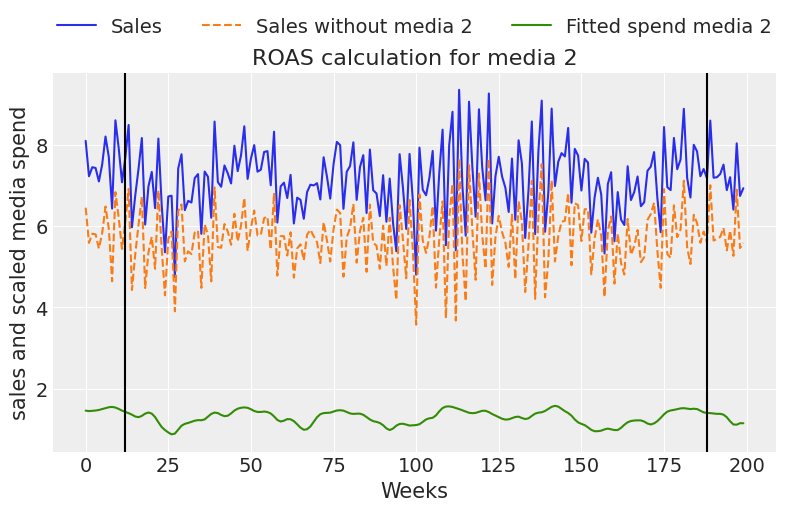

In [ ]:

plt.plot(y_hat, label = "Sales")
plt.plot(y_hat_m2, label = "Sales without media 2", ls="--")

plt.plot(m2, label = "Fitted spend media 2")



plt.axvline(12, 0, 1, color="black")
plt.axvline(200-12, 0, 1, color="black")


plt.xlabel('Weeks')
plt.ylabel('sales and scaled media spend')
plt.title('ROAS calculation for media 2')
 
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True)
plt.show()

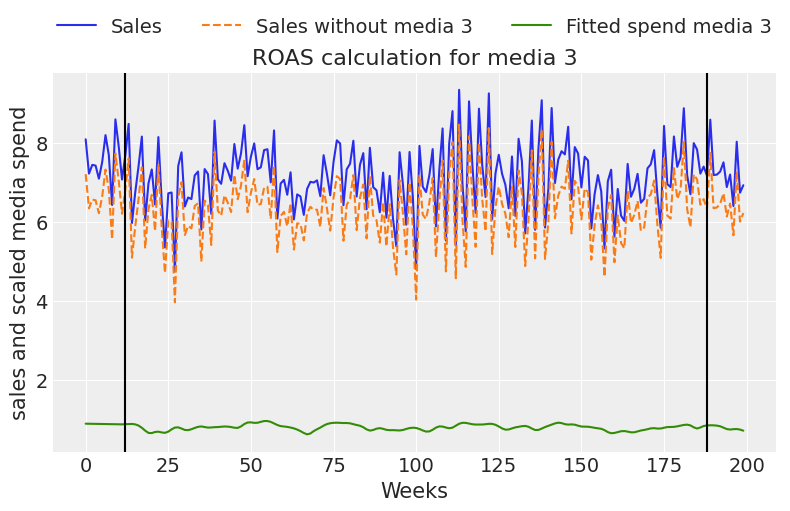

In [ ]:

plt.plot(y_hat, label = "Sales")
plt.plot(y_hat_m3, label = "Sales without media 3", ls="--")

plt.plot(fitted_m3, label = "Fitted spend media 3")


plt.axvline(12, 0, 1, color="black")
plt.axvline(200-12, 0, 1, color="black")


plt.xlabel('Weeks')
plt.ylabel('sales and scaled media spend')
plt.title('ROAS calculation for media 3')

plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True)
plt.show()

### Media Mix Optimization

Media mix models are also used to find the optimal media mix that maximizes the revenue under a budget constraint in the selected time period. Suppose the total budget of all media in the change period $(t0; t1)$ is $C$, the optimal media mix for this period $X^o = \{ x_{t,m}^o , t_0 \le t \le t_1,1 \le m \le M\}$ is obtained by

$$
maximise \sum_{t_0\le t\le t_1+L-1} \hat{Y}(x_{t-L+1,m}, ...,x_{t,m}; 1 \le m \le M ; 𝝓)
$$

$$
subjet to \sum_{t_0\le t\le t_1} \sum_{1 \le m \le M}x_{t,m}=C
$$

In [23]:
!pip install tqdm 
from tqdm import tqdm_notebook as tqdm

Suppose we have a montly total budget of 200K to invest in marketing, let's first trasform  the amount in accord with the normalization applied to the media spend:

In [28]:
budget_std = min_max_scaler.transform([[50000]])[0]
budget_std

array([67.19192916])

In [29]:
import scipy as sp
from scipy.optimize import minimize
from numpy.random import rand
from scipy.optimize import dual_annealing


media_1_opt = []
media_2_opt = []
media_3_opt = []
results = []


for i in tqdm(range(20)):
    burnin=500
    L=12
    s = np.random.randint(1,1000-burnin)
    t = np.random.binomial(1,.5)
    intercept = trace1['intercept'].reshape(2,1000)[t][burnin:][s]
    lamb = trace1['lamb'].reshape(2,1000)[t][burnin:][s]
    
    nu_sample1, nu_sample2, nu_sample3 = trace1['nu'][:,0].reshape(2,1000)[t][burnin:][s],    trace1['nu'][:,1].reshape(2,1000)[t][burnin:][s],     trace1['nu'][:,2].reshape(2,1000)[t][burnin:][s]
    a_sample1, a_sample2, a_sample3 =    trace1['alpha'][:,0].reshape(2,1000)[t][burnin:][s], trace1['alpha'][:,1].reshape(2,1000)[t][burnin:][s],  trace1['alpha'][:,2].reshape(2,1000)[t][burnin:][s]
    t_sample1, t_sample2, t_sample3 =    trace1['theta'][:,0].reshape(2,1000)[t][burnin:][s], trace1['theta'][:,1].reshape(2,1000)[t][burnin:][s],  trace1['theta'][:,2].reshape(2,1000)[t][burnin:][s]
    b_sample1, b_sample2, b_sample3 =    trace1['beta'][:,0].reshape(2,1000)[t][burnin:][s],  trace1['beta'][:,1].reshape(2,1000)[t][burnin:][s],  trace1['beta'][:,2].reshape(2,1000)[t][burnin:][s]
    
    #for i in range(10):

    def objective(x, sign=-1.0):
      fitted_m1 = [saturation(x, nu_sample1, b_sample1) for x in carryover(x.reshape(30,3)[:,0], a_sample1, L, theta = t_sample1)]
      fitted_m2 = [saturation(x, nu_sample2, b_sample2) for x in carryover(x.reshape(30,3)[:,1], a_sample2, L, theta = t_sample2)]
      fitted_m3 = [saturation(x, nu_sample3, b_sample3) for x in carryover(x.reshape(30,3)[:,2], a_sample3, L, theta = t_sample3)] 
      return sign * np.sum(intercept + fitted_m1 + fitted_m2 + fitted_m3 + (lamb * price_variable)[:30])
    

    bnds = tuple(map(tuple, np.array([(0,budget_std) for i in range(90)])))

    # initial guess
    pt = sp.random.uniform(0, 1, 90)
    
    # constrains total budget 
    cons = ({'type': 'eq',  'fun' : lambda x:  budget_std - x.sum(), }) 
    result = minimize(objective, pt, constraints=cons, bounds=bnds, method='SLSQP')

    ## append solution
    solution = result['x']
    media_1_opt.append(solution.reshape(30,3)[:,0])
    media_2_opt.append(solution.reshape(30,3)[:,1])
    media_3_opt.append(solution.reshape(30,3)[:,2])
    results.append(result)


  0%|          | 0/20 [00:00<?, ?it/s]

Averange return:

In [30]:
funs = []
for i in range (20):
    funs.append(results[i]['fun'])
print("Scaled: ", -np.mean(funs))
print("Not Scaed: ", min_max_scaler.inverse_transform(-np.mean(funs).reshape(1, -1))[0][0])

Scaled:  253.2928521767003
Not Scaed:  186745.49977261646


In [31]:
print("Optimal spend per 30 days on Media 1: ", round(sum(np.mean(media_1_opt, axis=0)),3), " and SD: ",round(sum(np.std(media_1_opt, axis=0)),3) )
print("Optimal spend per 30 days on Media 2: ", round(sum(np.mean(media_2_opt, axis=0)),3), " and SD: ",round(sum(np.std(media_2_opt, axis=0)),3) )
print("Optimal spend per 30 days on Media 3: ", round(sum(np.mean(media_3_opt, axis=0)),3), " and SD: ",round(sum(np.std(media_3_opt, axis=0)),3) )
print("-> Full budget equal to 14.38 (standardized)")

Optimal spend per 30 days on Media 1:  20.346  and SD:  16.613
Optimal spend per 30 days on Media 2:  28.28  and SD:  15.802
Optimal spend per 30 days on Media 3:  18.567  and SD:  18.938
-> Full budget equal to 14.38 (standardized)


In [32]:
print("Optimal spend per 30 days on Media 1: ", round(min_max_scaler.inverse_transform(sum(np.mean(media_1_opt, axis=0)).reshape(1, -1))[0][0],3), " and SD: ",round(min_max_scaler.inverse_transform(sum(np.std(media_1_opt, axis=0)).reshape(1, -1))[0][0],3))
print("Optimal spend per 30 days on Media 2: ", round(min_max_scaler.inverse_transform(sum(np.mean(media_2_opt, axis=0)).reshape(1, -1))[0][0],3), " and SD: ",round(min_max_scaler.inverse_transform(sum(np.std(media_2_opt, axis=0)).reshape(1, -1))[0][0],3))
print("Optimal spend per 30 days on Media 3: ", round(min_max_scaler.inverse_transform(sum(np.mean(media_3_opt, axis=0)).reshape(1, -1))[0][0],3), " and SD: ",round(min_max_scaler.inverse_transform(sum(np.std(media_3_opt, axis=0)).reshape(1, -1))[0][0],3))
print("-> Full budget equal to 50 000")

Optimal spend per 30 days on Media 1:  15577.636  and SD:  12834.746
Optimal spend per 30 days on Media 2:  21407.565  and SD:  12239.122
Optimal spend per 30 days on Media 3:  14270.593  and SD:  14543.08
-> Full budget equal to 500 000


Given a total budget of 14.38 the allocation of spend is 4.3 for the first channel, 6.557 for the second channel and 3.5 for the 3rd channels:

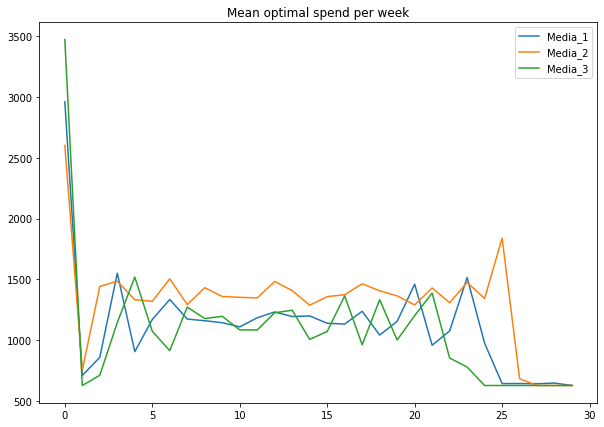

In [33]:
#resources allocation (not standardized)

plt.plot(min_max_scaler.inverse_transform([np.mean(np.array(media_1_opt), axis=0)])[0])
plt.plot(min_max_scaler.inverse_transform([np.mean(np.array(media_2_opt), axis=0)])[0])
plt.plot(min_max_scaler.inverse_transform([np.mean(np.array(media_3_opt), axis=0)])[0])
plt.legend(labels=['Media_1','Media_2','Media_3'])

plt.title('Mean optimal spend per week')
plt.show()

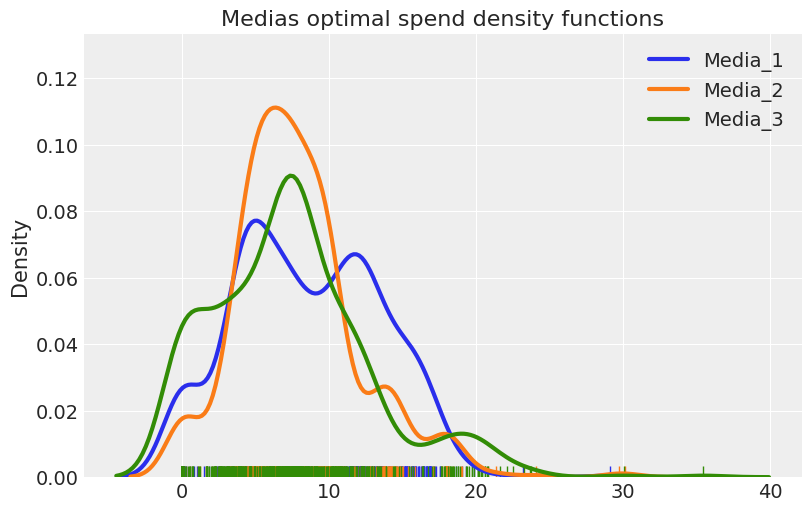

In [ ]:
sns.distplot(media_1_opt, hist = False, kde = True, kde_kws = {'linewidth': 3},rug = True)
sns.distplot(media_2_opt, hist = False, kde = True, kde_kws = {'linewidth': 3},rug = True)
sns.distplot(media_3_opt, hist = False, kde = True, kde_kws = {'linewidth': 3},rug = True)
plt.legend(labels=['Media_1','Media_2','Media_3'])

plt.title('Medias optimal spend density functions')
plt.show()
